#  Importing

## stonesoup

In [2]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater
from stonesoup.types.state import GaussianState
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

## Misc

In [3]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Gen Ground Truth Flight Path

## Constants

In [4]:
start_time = datetime.now().replace(microsecond=0)
np.random.seed(1991)

num_steps = 20

rel_pos = np.array([[0],[0],[0]])

num = 5

xmin = -20
xmax = 20
ymin = 20
ymax = 40
zmin = -1
zmax = 1

vmin_xy = 0.5
vmax_xy = 3

vmin_z = -0.1
vmax_z = 0.1

rng = np.random.default_rng()

## Transition model
We declare the transition models with 0 noise because why should our ground truth have noise?

In [5]:
transition_model_cart = CombinedLinearGaussianTransitionModel([ConstantVelocity(0),
                                                              ConstantVelocity(0),
                                                              ConstantVelocity(0)])

## Helper Function Declarations

In [6]:
def randGen(maxVal, minVal):
    return minVal + rng.random()*(maxVal-minVal)

def cart2azel(state, relpos):
    pos = state.state_vector[[0,2,4]] - relpos
    el = np.arcsin(pos[2] / np.sqrt(pos.T@pos))[0]
    az = np.arctan2(pos[1], pos[0])
    return [[el], [0], [az], [0]]

## Generate Ground Truth

In [7]:
truth_arr_cart = [] # x dx y dy z dy
truth_arr_sph = [] # el az
timesteps = [start_time]
for kk  in range(num):
    x = randGen(xmax, xmin)
    y = randGen(ymax, ymin)
    z = randGen(zmax, zmin)
    dx = randGen(vmax_xy, vmin_xy) * np.cos(rng.random()*2*np.pi)
    dy = randGen(vmax_xy, vmin_xy) * np.sin(rng.random()*2*np.pi)
    dz = randGen(zmax, zmin)
    xdxydy0 = [x, dx, y, dy, z, dz]
    truth_cart = GroundTruthPath([GroundTruthState(xdxydy0, timestamp = start_time)])
    truth_sph = GroundTruthPath([GroundTruthState(cart2azel(truth_cart[0], rel_pos), timestamp = start_time)])
    for k in range(1, num_steps+1):
        timesteps.append(start_time + timedelta(seconds = k))
        truth_cart.append(GroundTruthState(
                transition_model_cart.function(truth_cart[k-1], noise=True, time_interval=timedelta(seconds=1)),
                timestamp=timesteps[k]))
        truth_sph.append(GroundTruthState(cart2azel(truth_cart[k-1], rel_pos), timestamp = timesteps[k]))
    truth_arr_cart.append(truth_cart)
    truth_arr_sph.append(truth_sph)

## Plotting Ground Truth
Each line represents a path.

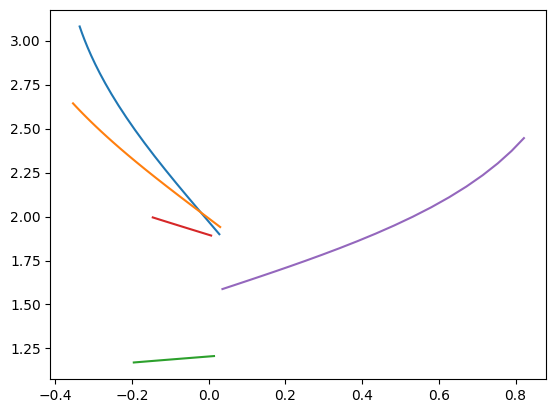

In [8]:
for path in truth_arr_sph:
    plot = np.array([point.state_vector for point in path])
    plt.plot(plot[:,0], plot[:,2])
plt.show()

# Simulate Measurements

In [9]:
measurement_model = LinearGaussian(
    ndim_state=4,  # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[0.005**2, 0],  # Covariance matrix for Gaussian PDF
                          [0, 0.005**2]])
    )

In [10]:
measurements = []
for truth in truth_arr_sph:
    meas = []
    for state in truth:
        measurement = measurement_model.function(state, noise=True)
        meas.append(Detection(measurement,
                                      timestamp=state.timestamp,
                                      measurement_model=measurement_model))
    measurements.append(meas)

# Kalman Filter
This model allows us to make predictions of the following positions with the attempt of becoming closer to the true values.

In [11]:
transition_model_sph = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.02), # Elevation
                                                          ConstantVelocity(0.02)]) # Azimuth
predictor = KalmanPredictor(transition_model_sph)
updater = KalmanUpdater(measurement_model)

In [12]:
priors = [GaussianState([[measurement[0].state_vector[0]], [0], [measurement[1].state_vector[1]], [0]], 
                      np.diag([1.5, 0.5, 1.5, 0.5]), 
                      timestamp=start_time) for measurement in measurements]

tracks_sph = []

for i in range(len(priors)):
    track = Track()
    for measurement in measurements[i]:
        prediction = predictor.predict(priors[i], timestamp=measurement.timestamp)
        hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
        post = updater.update(hypothesis)
        track.append(post)
        priors[i] = track[-1]
    tracks_sph.append(track)

# Plotting Results

## Last Target Plot

In [13]:
truth_vecs = np.array([truth_vec.state_vector for truth_vec in truth_sph])
meas_vecs = np.array([meas.state_vector for meas in measurements[4]])
track_vecs = np.array([prediction.state_vector for prediction in track])

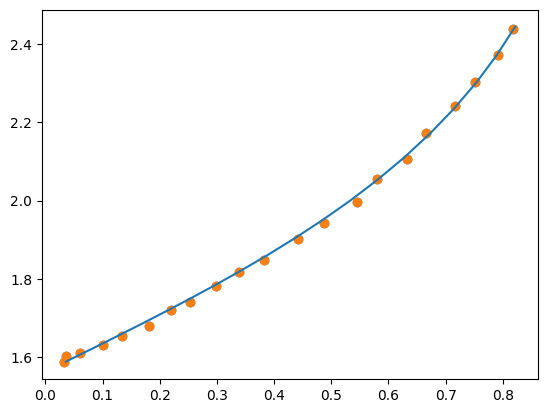

In [14]:
plt.plot(truth_vecs[:,0], truth_vecs[:,2])
plt.scatter(meas_vecs[:,0], meas_vecs[:,1])
plt.scatter(track_vecs[:,0], track_vecs[:,2])
plt.show()

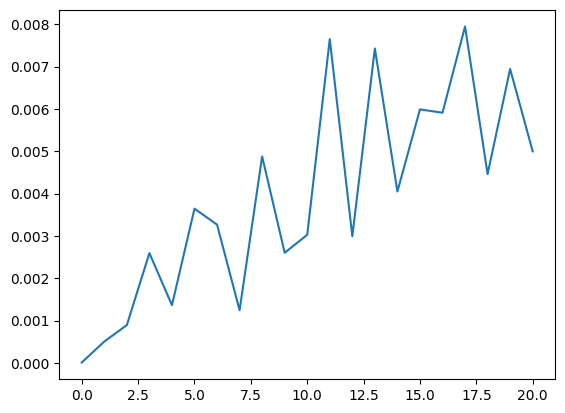

In [59]:
dif_vecs = truth_vecs[:,:,0] - track_vecs[:,:,0]

magnitudes = (dif_vecs**2)@np.ones([4,1])

plt.plot(magnitudes)
plt.show()

In [60]:
truth_vecs[0]

array([[0.03581676],
       [0.        ],
       [1.58771126],
       [0.        ]])

## All Targets Plot

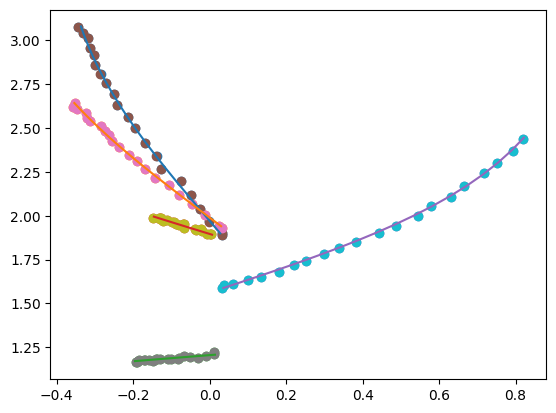

In [64]:
# Truth
for path in truth_arr_sph:
    plot = np.array([point.state_vector for point in path])
    plt.plot(plot[:,0], plot[:,2])

# Measurements
for measurement in measurements:
    meas_vecs = np.array([meas.state_vector for meas in measurement])
    plt.scatter(meas_vecs[:,0], meas_vecs[:,1])

# Predicted
for preds in tracks_sph:
    track_vecs = np.array([prediction.state_vector for prediction in preds])
    plt.scatter(track_vecs[:,0], track_vecs[:,2])

plt.show()

# References


[1]

Kalman 1960, A New Approach to Linear Filtering and Prediction Problems, Transactions of the ASME, Journal of Basic Engineering, 82 (series D), 35 (https://pdfs.semanticscholar.org/bb55/c1c619c30f939fc792b049172926a4a0c0f7.pdf?_ga=2.51363242.2056055521.1592932441-1812916183.1592932441)

[2]

Anderson & Moore 1979, Optimal filtering, (http://users.cecs.anu.edu.au/~john/papers/BOOK/B02.PDF)
